TODO:

De continuat cu o abordare multimodala, utilizand VGG-16 preantrenat, caruia i se va antrena ultimul strat, primele 4 fiind frozen. Ideal ar fi sa gasesc alte baze de date pe care sa antrenez modelul. De implementat abordarea multimodala.

In [1]:
import shutil
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from palmtools import plotModelStats
from palmtools import datasetCounter
from palmtools import extractFeatures
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import callbacks
import palmtools
import const
import os

In [4]:
files1 = palmtools.getFilesArray(const.ROI,const.PALM)
files2 = palmtools.getFilesArray(const.GENERATED,const.PALM)
#files3 = palmtools.getFilesArray(const.GENERATED,const.DORSAL)
palmtools.createDataset(const.PALM,files1,0,0,1)
palmtools.createDataset(const.PALM,files2,0.7,0.3,0)

In [5]:
image_gen = ImageDataGenerator(rescale = 1./255)

In [6]:
palm_train_generator = image_gen.flow_from_directory(
    const.PALM_DS_DIR + const.TRAIN_DIR,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)
palm_valid_generator = image_gen.flow_from_directory(
    const.PALM_DS_DIR + const.VALID_DIR,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)
palm_test_generator = image_gen.flow_from_directory(
    const.PALM_DS_DIR + const.TEST_DIR,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

Found 4480 images belonging to 160 classes.
Found 1920 images belonging to 160 classes.
Found 640 images belonging to 160 classes.


In [9]:
# initializare model preantrenat VGG-16, fara clasificator
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

2022-01-24 22:12:37.946558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 22:12:38.628564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 22:12:38.629163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 22:12:38.637104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [11]:
# inghetarea straturilor pentru a preveni alterarea ponderilor preantrenate
conv_base.trainable = False
conv_base.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [12]:
palm_train_features, palm_train_labels = extractFeatures(conv_base,const.PALM_DS_DIR + const.TRAIN_DIR,4480)
palm_valid_features, palm_valid_labels = extractFeatures(conv_base,const.PALM_DS_DIR + const.VALID_DIR,1920)
palm_test_features, palm_test_labels = extractFeatures(conv_base,const.PALM_DS_DIR + const.TEST_DIR,640)

Found 4480 images belonging to 160 classes.


2022-01-24 22:13:01.592633: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-01-24 22:13:07.835822: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-24 22:13:08.634102: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Found 1920 images belonging to 160 classes.
Found 640 images belonging to 160 classes.


In [13]:
clasificator = models.Sequential()
clasificator.add(layers.Flatten())
clasificator.add(layers.Dense(4096, activation='relu', input_dim=(4 * 4 * 512)))
clasificator.add(layers.Dropout(0.3))
clasificator.add(layers.Dense(4096, activation='relu'))
#clasificator.add(layers.Dropout(0.2))
clasificator.add(layers.Dense(160, activation='softmax'))
clasificator.compile(loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)
clasificator_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="Models/Checkpoints/Classifier/",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_complet_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="Models/Checkpoints/Model_complet/",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [15]:
history_clasificator = clasificator.fit(palm_train_features,palm_train_labels,
                      epochs=70,
                      batch_size=32,
                      validation_data=(palm_valid_features,palm_valid_labels),
                                       callbacks=[early_stopping,clasificator_checkpoint_callback])


Epoch 1/70
140/140 [==============================] - ETA: 0s - loss: 6.0694 - accuracy: 0.0246

2022-01-24 22:16:42.493317: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/Checkpoints/Classifier/assets
140/140 [==============================] - 17s 119ms/step - loss: 6.0694 - accuracy: 0.0246 - val_loss: 4.0620 - val_accuracy: 0.0938
Epoch 2/70
140/140 [==============================] - 16s 115ms/step - loss: 3.7111 - accuracy: 0.1346 - val_loss: 2.9749 - val_accuracy: 0.2693
Epoch 3/70
140/140 [==============================] - 16s 116ms/step - loss: 2.6339 - accuracy: 0.3058 - val_loss: 1.7112 - val_accuracy: 0.5167
Epoch 4/70
140/140 [==============================] - 16s 113ms/step - loss: 1.8721 - accuracy: 0.4960 - val_loss: 1.0609 - val_accuracy: 0.7052
Epoch 5/70
140/140 [==============================] - 16s 113ms/step - loss: 1.3974 - accuracy: 0.5998 - val_loss: 0.8133 - val_accuracy: 0.7604
Epoch 6/70
140/140 [==============================] - 16s 114ms/step - loss: 1.0530 - accuracy: 0.6875 - val_loss: 0.7365 - val_accuracy: 0.7859
Epoch 7/70
140/140 [==============================] - 16s 115ms/step 

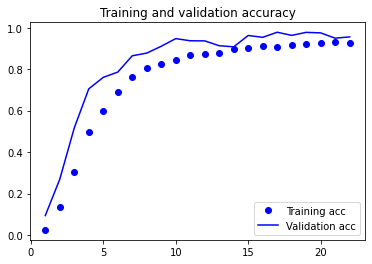

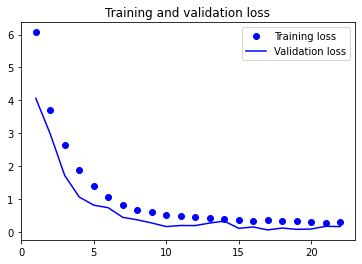

In [16]:
plotModelStats(history_clasificator)


In [17]:
print("Numarul de parametrii antrenabili: ",len(conv_base.trainable_weights))
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if ('block4' in layer.name) or ('block5' in layer.name):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print("Numarul de parametrii antrenabili: ",len(conv_base.trainable_weights))
conv_base.compile(loss='categorical_crossentropy',
                  metrics=['acc'])

Numarul de parametrii antrenabili:  0
Numarul de parametrii antrenabili:  12


In [18]:
model_complet = models.Sequential()

model_complet.add(conv_base)
model_complet.add(clasificator)

model_complet.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(learning_rate=1e-5),
                      metrics=['accuracy'])

In [20]:
history_complet = model_complet.fit(palm_train_generator,
                      epochs=20,
                      batch_size=32,
                      validation_data=palm_valid_generator,
                                   callbacks=[early_stopping,model_complet_checkpoint_callback])

Epoch 1/20


2022-01-24 22:23:21.356818: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-24 22:23:21.356936: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-24 22:23:22.163143: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-24 22:23:22.768372: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

140/140 [==============================] - 102s 682ms/step - loss: 0.2973 - accuracy: 0.9406 - val_loss: 0.1855 - val_accuracy: 0.9573
Epoch 2/20
140/140 [==============================] - 103s 733ms/step - loss: 0.1451 - accuracy: 0.9596 - val_loss: 0.0501 - val_accuracy: 0.9901
Epoch 3/20
140/140 [==============================] - 93s 665ms/step - loss: 0.1456 - accuracy: 0.9625 - val_loss: 0.1086 - val_accuracy: 0.9703
Epoch 4/20
140/140 [==============================] - 92s 659ms/step - loss: 0.1128 - accuracy: 0.9699 - val_loss: 0.0542 - val_accuracy: 0.9844
Epoch 5/20
140/140 [==============================] - 93s 664ms/step - loss: 0.0858 - accuracy: 0.9748 - val_loss: 0.2246 - val_accuracy: 0.9474
Epoch 6/20
140/140 [==============================] - 92s 659ms/step - loss: 0.0829 - accuracy: 0.9775 - val_loss: 0.0393 - val_accuracy: 0.9896
Epoch 7/20
140/140 [==============================] - 97s 695ms/step - loss: 0.0833 - accuracy: 0.9772 - val_loss: 0.0234 - val_accuracy: 0

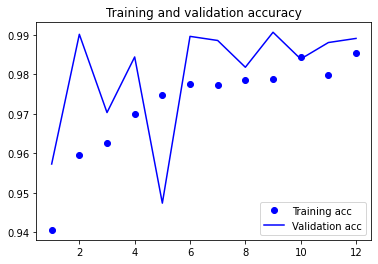

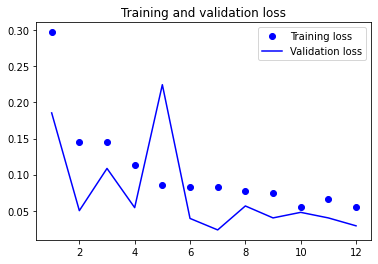

In [23]:
plotModelStats(history_complet)

In [24]:
test_loss, test_acc = model_complet.evaluate(palm_test_generator, steps=20)
print('test acc:', test_acc)

20/20 [==============================] - 10s 506ms/step - loss: 0.0024 - accuracy: 0.9984
test acc: 0.9984375238418579


In [29]:
conv_base.save('Models/3/conv_base-24.01.2022.h5')
clasificator.save('Models/3/clasificator-24.01.2022.h5')
model_complet.save('Models/3/model_complet-24.01.2022.h5')

In [28]:
import pickle
with open('Models/3/history_clasificator.bin', 'wb') as file_pi:
    pickle.dump(history_clasificator.history, file_pi)

In [31]:
output = model_complet.predict(palm_test_generator)